In [4]:
import pandas as pd
import os
import re
import tensorflow as tf
import random

# Load dataset

In [1]:
from pathlib import Path
import requests
import zipfile

data_path = Path("data")

if data_path.is_dir():
  print(f"{data_path} dicretory already exist")
else:
  data_path.mkdir(parents=True, exist_ok=True)
  print(f"Creating {data_path} directory...")

response = requests.get("https://www.kaggle.com/api/v1/datasets/download/sbhatti/financial-sentiment-analysis")
with open(data_path / "financial-sentiment-analysis.zip", "wb") as f:
  f.write(response.content)
with zipfile.ZipFile(data_path / "financial-sentiment-analysis.zip", "r") as zip_file:
  print(f"Extracting financial-sentiment-analysis.zip...")
  zip_file.extractall(data_path)

Creating data directory...
Extracting financial-sentiment-analysis.zip...


In [5]:
data_df = pd.read_csv(data_path / "data.csv")
data_df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
random_number = random.randint(0, len(data_df))
data_df.loc[random_number:random_number+5, 'Sentence'].tolist()

['Oka specialises in new construction , renovation work of residential and non-residential building as well as premises for industrial and logistical use .',
 'Neste Oil s refineries have a combined crude oil refining capacity of approximately 260,000 barrels a day .',
 'The net sales decreased to EUR 49.8 million from EUR 59.9 million .',
 'In 2007 , Etteplan had turnover of EUR125 .2 m.',
 'Pretax profit rose to EUR 0.6 mn from EUR 0.4 mn in the corresponding period in 2005 .',
 'Net sales of Finnish Sanoma Learning & Literature , of Finnish media group Sanoma , decreased by 3.6 % in January-June 2009 totalling EUR 162.8 mn , down from EUR 168.8 mn in the corresponding period in 2008 .']

Text(0.5, 1.0, 'Label count')

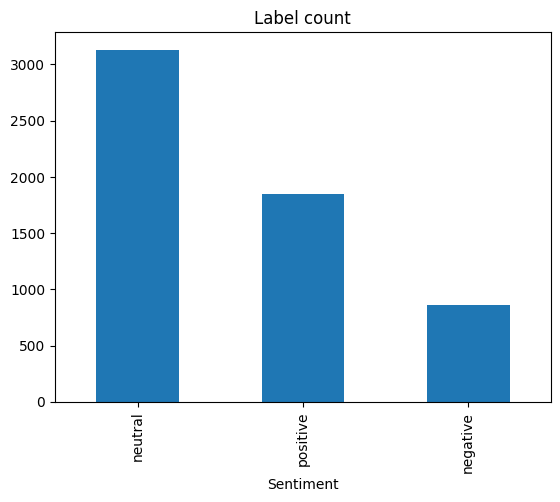

In [ ]:
data_df['Sentiment'].value_counts().plot.bar()
plt.title("Label count")

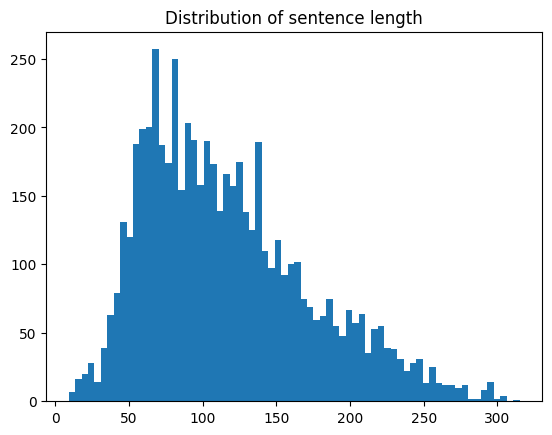

95 percentile length : 226.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sentence_length = [len(text) for text in data_df['Sentence']]
max_length = np.percentile(sentence_length, 95)

plt.hist(sentence_length, bins=70)
plt.title("Distribution of sentence length")
plt.show()
print(f"95 percentile length : {max_length}")

# Processing data

In [ ]:
def clean_txt(text):
  pattern = r"[^a-zA-Z0-9\s,']"
  text = re.sub(pattern, '', text)
  return text

In [ ]:
label_to_value = {
    'neutral': 0,
    'positive': 1,
    'negative': 2
}

data_df['cleaned sentence'] = data_df['Sentence'].apply(clean_txt)
X = data_df['cleaned sentence']
y = data_df['Sentiment'].map(label_to_value)
X, y

(0       The GeoSolutions technology will leverage Bene...
 1       ESI on lows, down 150 to 250 BK a real possibi...
 2       For the last quarter of 2010 , Componenta 's n...
 3       According to the FinnishRussian Chamber of Com...
 4       The Swedish buyout firm has sold its remaining...
                               ...                        
 5837    RISING costs have forced packaging producer Hu...
 5838    Nordic Walking was first used as a summer trai...
 5839    According shipping company Viking Line , the E...
 5840    In the building and home improvement trade , s...
 5841    HELSINKI AFX  KCI Konecranes said it has won a...
 Name: cleaned sentence, Length: 5842, dtype: object,
 0       1
 1       2
 2       1
 3       0
 4       0
        ..
 5837    2
 5838    0
 5839    0
 5840    0
 5841    1
 Name: Sentiment, Length: 5842, dtype: int64)

In [ ]:
X[3]

'According to the FinnishRussian Chamber of Commerce , all the major construction companies of Finland are operating in Russia '

In [ ]:
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test =X[train_size+val_size:], y[train_size+val_size:]

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(4673, 4673, 584, 584, 585, 585)

# Create tokenizer and encoding

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_length = 64

X_train_encoded = tokenizer.batch_encode_plus(X_train,
                                              padding=True,
                                              truncation=True,
                                              max_length=max_length,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(X_val,
                                            padding=True,
                                            truncation=True,
                                            max_length=max_length,
                                            return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(X_test,
                                             padding=True,
                                             truncation=True,
                                             max_length=max_length,
                                             return_tensors='tf')

# Build a model

In [ ]:
from transformers import TFBertForSequenceClassification

num_labels = len(np.unique(y))

model = TFBertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=num_labels)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [ ]:
num_epochs = 3
batch_size = 16
input_dict = {
    'input_ids': X_train_encoded['input_ids'],
    'token_type_ids': X_train_encoded['token_type_ids'],
    'attention_mask': X_train_encoded['attention_mask']
}
val_input_dict = {
    'input_ids': X_val_encoded['input_ids'],
    'token_type_ids': X_val_encoded['token_type_ids'],
    'attention_mask': X_val_encoded['attention_mask']
}

history = model.fit(x=input_dict,
                    y=y_train.values,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(val_input_dict, y_val.values))

Epoch 1/3
293/293 [==============================] - 106s 234ms/step - loss: 1.0339 - accuracy: 0.5037 - val_loss: 1.1249 - val_accuracy: 0.5377
Epoch 2/3
293/293 [==============================] - 65s 220ms/step - loss: 1.0281 - accuracy: 0.4963 - val_loss: 0.9871 - val_accuracy: 0.5377
Epoch 3/3
293/293 [==============================] - 68s 233ms/step - loss: 1.0559 - accuracy: 0.4772 - val_loss: 0.9763 - val_accuracy: 0.5377


# Evaluate a model

In [ ]:
test_loss, test_acc = model.evaluate(X_test_encoded,
                                     y_test.values)

print(f"Test loss : {test_loss:.5f} | Test accuracy : {test_acc:.3f}")

19/19 [==============================] - 3s 133ms/step - loss: 1.0252 - accuracy: 0.5128
Test loss : 1.02525 | Test accuracy : 0.513


In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(X_test_encoded)
pred_label = tf.argmax(preds.logits, axis=1).numpy()

print(classification_report(y_test, pred_label))

19/19 [==============================] - 2s 123ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       300
           1       0.00      0.00      0.00       182
           2       0.00      0.00      0.00       103

    accuracy                           0.51       585
   macro avg       0.17      0.33      0.23       585
weighted avg       0.26      0.51      0.35       585



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Save and load model, tokenizer

In [ ]:
from pathlib import Path

model_path = Path("model_tokenizer")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "bert_classifier.pth"
tokenizer_name = "bert_tokenizer.pth"

model_save_path = model_path / model_name
tokenizer_save_path = model_path / tokenizer_name

tokenizer.save_pretrained(tokenizer_save_path)
model.save_pretrained(model_save_path)

In [ ]:
loaded_tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)
loaded_model = TFBertForSequenceClassification.from_pretrained(model_save_path)

Some layers from the model checkpoint at model_tokenizer/bert_classifier.pth were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at model_tokenizer/bert_classifier.pth.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# Make prediction

In [ ]:
def make_prediction(text: str, tokenizer, model):
  text = clean_txt(text)

  if not isinstance(text, list):
    text = [text]

  text_endcoded = tokenizer.batch_encode_plus(text,
                                              padding=True,
                                              truncation=True,
                                              max_length=128,
                                              return_tensors='tf')
  inputs_dict = {
    'input_ids': text_endcoded['input_ids'],
    'token_type_ids': text_endcoded['token_type_ids'],
    'attention_mask': text_endcoded['attention_mask']
  }

  label_dict = {
    0: "neutral",
    1: "positive",
    2: "negative"
  }

  preds = model.predict(inputs_dict)
  pred_label = label_dict[tf.argmax(preds.logits, axis=1).numpy().item()]
  return pred_label

In [ ]:
text = "net profit decrease"

make_prediction(text, loaded_tokenizer, loaded_model)

1/1 [==============================] - 0s 44ms/step


'neutral'